# AI training

This will become the main AI training method/function


### Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import os
new_dir_path = 'saved_model'

os.makedirs(new_dir_path, exist_ok=True) 


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    
])

In [ ]:
total_ds = ImageFolder('/content/drive/MyDrive/ManishProjects/facemask_dataset/dataset', transform=transform)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(total_ds)),
    total_ds.targets,
    # stratify=total_ds.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)


# generate subset based on indices
train_ds = Subset(total_ds, train_indices)
eval_ds = Subset(total_ds, test_indices)

In [ ]:
batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
eval_dl = DataLoader(eval_ds, batch_size, num_workers=2, pin_memory=True)

Visualisation of data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 128, 128])


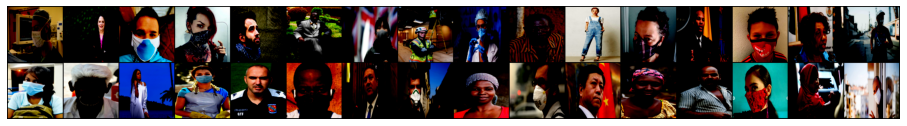

In [ ]:
batch_size=32
train_dl2 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
for images, _ in train_dl2:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
classes = total_ds.classes

### Model construction and Training

In [ ]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = len(classes)
learning_rate = 0.00001
num_epochs = 100
device = 'cuda'
# device = 'cpu'


In [ ]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batch_norm2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(53824, 128)
        self.batch_norm3 = nn.BatchNorm1d(128)

        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.4)
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
               
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.batch_norm3(out)
        out = self.relu1(out)
        out = self.dropout(out)

        out = self.fc2(out)
        return out

In [ ]:
model = ConvNeuralNet(num_classes)
model = model.to(device)
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_dl)

In [ ]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_dl):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(model.state_dict(), '/saved_model')

            

Epoch [1/100], Loss: 1.3662
Epoch [2/100], Loss: 1.3791
Epoch [3/100], Loss: 1.4450
Epoch [4/100], Loss: 1.3386
Epoch [5/100], Loss: 1.6056
Epoch [6/100], Loss: 1.5115
Epoch [7/100], Loss: 1.3828
Epoch [8/100], Loss: 1.3003
Epoch [9/100], Loss: 1.4374
Epoch [10/100], Loss: 1.2911
Epoch [11/100], Loss: 1.4248
Epoch [12/100], Loss: 1.4551
Epoch [13/100], Loss: 1.2825
Epoch [14/100], Loss: 1.4004
Epoch [15/100], Loss: 1.2491
Epoch [16/100], Loss: 1.6096
Epoch [17/100], Loss: 1.2450
Epoch [18/100], Loss: 1.3361
Epoch [19/100], Loss: 1.0909
Epoch [20/100], Loss: 1.1660
Epoch [21/100], Loss: 1.1243
Epoch [22/100], Loss: 1.1715
Epoch [23/100], Loss: 1.4770
Epoch [24/100], Loss: 1.1938
Epoch [25/100], Loss: 1.2429
Epoch [26/100], Loss: 1.3441
Epoch [27/100], Loss: 1.0422
Epoch [28/100], Loss: 1.0802
Epoch [29/100], Loss: 1.0339
Epoch [30/100], Loss: 0.9993
Epoch [31/100], Loss: 1.4199
Epoch [32/100], Loss: 1.3028
Epoch [33/100], Loss: 1.2330
Epoch [34/100], Loss: 1.1639
Epoch [35/100], Loss: 1

### Evaluation

In [ ]:
model = ConvNeuralNet(num_classes)
model.load_state_dict(torch.load('/saved_model'))
model = model.to(device)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for pred_images, pred_labels in eval_dl:
        pred_images = pred_images.to(device)
        pred_labels = pred_labels.to(device)
        pred_outputs = model(pred_images)
        _, pred_predicted = torch.max(pred_outputs.data, 1)
        total += pred_labels.size(0)
        correct += (pred_predicted == pred_labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(len(eval_dl.dataset), 100 * correct / total))


Accuracy of the network on the 51 train images: 23.529411764705884 %


### Application mode

**Note:**Make a folder within a folder and add the image to test in that. Change the path of `app_image` to point to the outer folder.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
app_image = ImageFolder('/content/drive/MyDrive/ManishProjects/facemask_dataset/mahish_project1_app', transform=transform)
app_dl = DataLoader(app_image, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model = ConvNeuralNet(num_classes)
model.load_state_dict(torch.load('/saved_model'))
model = model.to(device)

with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in app_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)



In [ ]:
print('The predicted class is:  ' , classes[predicted.item()])

The predicted class is:   4.n95


### Evaluation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

eval_labels = pred_labels.detach().cpu()
eval_predictions = pred_predicted.detach().cpu()

print(classification_report(eval_labels, eval_predictions))


              precision    recall  f1-score   support

           0       0.42      0.43      0.43        23
           1       0.00      0.00      0.00         6
           2       0.14      0.06      0.08        18
           3       0.12      0.25      0.17         4

    accuracy                           0.24        51
   macro avg       0.17      0.19      0.17        51
weighted avg       0.25      0.24      0.23        51

precision: [0.41666667 0.         0.14285714 0.125     ]
recall: [0.43478261 0.         0.05555556 0.25      ]
fscore: [0.42553191 0.         0.08       0.16666667]
support: [23  6 18  4]


<Figure size 6400x4800 with 0 Axes>

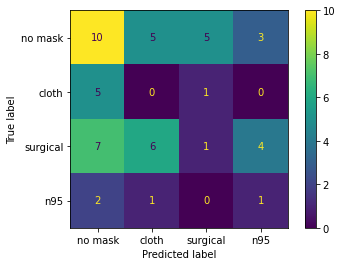

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import figure

figure(figsize=(80, 60), dpi=80)
cm = confusion_matrix(eval_labels, eval_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no mask', 'cloth', 'surgical', 'n95'])
disp.plot()

plt.show()

In [ ]:
cm

array([[10,  5,  5,  3],
       [ 5,  0,  1,  0],
       [ 7,  6,  1,  4],
       [ 2,  1,  0,  1]])